# Tennis Stroke Classification (Baseline Random Forest)

Assumptions:
- Columns include:
  - `stroke_label` (y target class)
  - `peak_abs_X`, `peak_abs_Y`, `peak_abs_Z`
  - `sign_Z_at_peak`
  - `duration_ms`
  - ratio features: `Z_over_X`, `Z_over_Y`, `X_over_Y`


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

FEATURES_PATH = "../processed/swing_features.csv"

df = pd.read_csv(FEATURES_PATH)

print("Loaded features shape:", df.shape)
df.head()

Loaded features shape: (20, 11)


,swing_file,session_id,stroke_label,peak_abs_X,peak_abs_Y,peak_abs_Z,sign_Z_at_peak,duration_ms,Z_over_X,Z_over_Y,X_over_Y
0,../processed/swings_segments/backhand/backhand...,backhands_watch-right,backhand,7.848593,9.741038,9.918324,-1.0,3900.0,1.263707,1.018200,0.805725
1,../processed/swings_segments/backhand/backhand...,backhands_watch-right,backhand,10.122697,11.718678,13.072875,-1.0,3550.0,1.291442,1.115559,0.863809
2,../processed/swings_segments/backhand/backhand...,backhands_watch-right,backhand,8.459282,11.353635,12.163086,-1.0,3510.0,1.437839,1.071294,0.745073
3,../processed/swings_segments/backhand/backhand...,backhands_watch-right,backhand,8.078526,11.166613,12.054246,-1.0,3760.0,1.492134,1.079490,0.723454
4,../processed/swings_segments/backhand/backhand...,backhands_watch-right,backhand,9.223503,10.771327,11.978202,-1.0,3530.0,1.298661,1.112045,0.856301


## 1. Exploratory Analysis

Class counts:
 stroke_label
forehand    7
serve       7
backhand    6
Name: count, dtype: int64


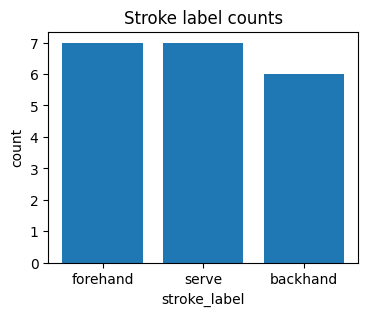

In [4]:
class_counts = df["stroke_label"].value_counts()
print("Class counts:\n", class_counts)

plt.figure(figsize=(4,3))
plt.bar(class_counts.index, class_counts.values)
plt.title("Stroke label counts")
plt.xlabel("stroke_label")
plt.ylabel("count")
plt.show()

## 2. Select features and target
Features
- Raw magnitudes (`peak_abs_X`, `peak_abs_Y`, `peak_abs_Z`)
- Direction info (`sign_Z_at_peak`)
- Ratios (`Z_over_X`, `Z_over_Y`, `X_over_Y`)
- Timing (`duration_ms`)

y is `stroke_label`.

In [ ]:
feature_cols = [
    "peak_abs_X",
    "peak_abs_Y",
    "peak_abs_Z",
    "sign_Z_at_peak",
    "Z_over_X",
    "Z_over_Y",
    "X_over_Y",
    "duration_ms"
]

X = df[feature_cols].copy()

y = df["stroke_label"].astype(str)

print("X shape:", X.shape)
print("y shape:", y.shape)
X.head()

X shape: (20, 8)
y shape: (20,)


,peak_abs_X,peak_abs_Y,peak_abs_Z,sign_Z_at_peak,Z_over_X,Z_over_Y,X_over_Y,duration_ms
0,7.848593,9.741038,9.918324,-1.0,1.263707,1.018200,0.805725,3900.0
1,10.122697,11.718678,13.072875,-1.0,1.291442,1.115559,0.863809,3550.0
2,8.459282,11.353635,12.163086,-1.0,1.437839,1.071294,0.745073,3510.0
3,8.078526,11.166613,12.054246,-1.0,1.492134,1.079490,0.723454,3760.0
4,9.223503,10.771327,11.978202,-1.0,1.298661,1.112045,0.856301,3530.0


## 3. Split into train/test


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # keep class balance similar in train/test
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 14
Test size: 6


## 4. Train a baseline classifier

RandomForest:
- handles non-linear boundaries
- handles different feature scales without normalization
- gives feature importances

Just to test if it is possible to separate serve vs forehand vs backhand at all

In [7]:
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}\n")

print("Classification report:\n")
print(classification_report(y_test, y_pred))

Test Accuracy: 1.000

Classification report:

              precision    recall  f1-score   support

    backhand       1.00      1.00      1.00         2
    forehand       1.00      1.00      1.00         2
       serve       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



## 5. Confusion matrix

Shows which strokes are getting mixed up

<Figure size 400x400 with 0 Axes>

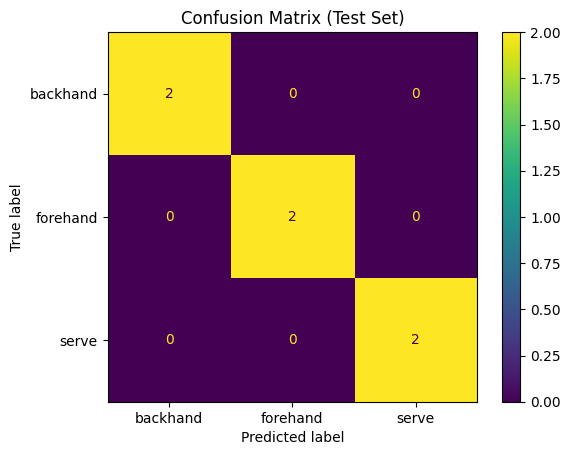

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

plt.figure(figsize=(4,4))
disp.plot(values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.show()

## 6. Feature importance

Most prominant features:
- `peak_abs_X` high for serves if serves are driven by pronation / forearm snap.
- `peak_abs_Z` and `sign_Z_at_peak` for forehand/backhand separation.

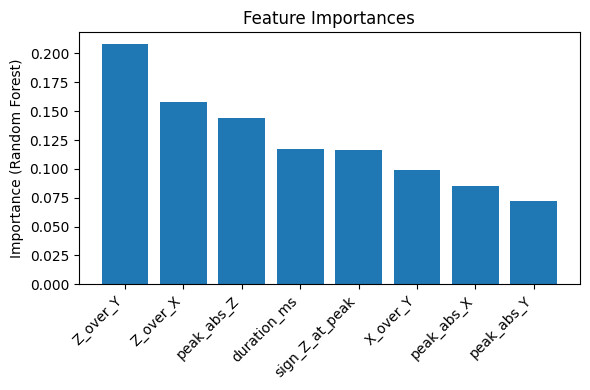

,feature,importance
0,Z_over_Y,0.207889
1,Z_over_X,0.157888
2,peak_abs_Z,0.144077
3,duration_ms,0.116959
4,sign_Z_at_peak,0.116709
5,X_over_Y,0.099075
6,peak_abs_X,0.084931
7,peak_abs_Y,0.072472


In [9]:
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.bar([feature_cols[i] for i in sorted_idx], importances[sorted_idx])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance (Random Forest)")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

feature_ranking = pd.DataFrame({
    'feature': [feature_cols[i] for i in sorted_idx],
    'importance': importances[sorted_idx]
})
feature_ranking

## 7. Save the trained model


In [12]:
import joblib

MODEL_OUT_PATH = "../processed/models/baseline_random_forest.pkl"
joblib.dump({
    'model': clf,
    'feature_cols': feature_cols,
    'classes': clf.classes_.tolist()
}, MODEL_OUT_PATH)

print("Saved model to:", MODEL_OUT_PATH)

Saved model to: ../processed/models/baseline_random_forest.pkl
